<a href="https://colab.research.google.com/github/yzhan480/CS536Final_Project/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
import numpy as np
from torchvision import datasets, transforms
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [16]:
!pip install torchsummary # use it 
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
dataset = datasets.MNIST(root='./data', download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [19]:
class Generator(nn.Module):
    def __init__(self, nc=1, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.generator(input)
        return output

In [20]:
class Discriminator_BN(nn.Module):
    def __init__(self, nc=1, ndf=64):
        super(Discriminator_BN, self).__init__()
        self.discriminator = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.discriminator(input)
        return output.view(-1, 1).squeeze(1)


In [22]:
class Discriminator_SN(nn.Module):
    def __init__(self, nc=1, ndf=64):
        super(Discriminator_SN, self).__init__()
        self.discriminator = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            spectral_norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),          
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            spectral_norm(nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False)),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.discriminator(input)
        return output.view(-1, 1).squeeze(1)


Training DCGAN during which its discriminator using batch normalization rather than spectral normalization.

In [24]:
netD_BN = Discriminator_BN().to(device)
netD_BN.apply(weights_init)
netG_BN = Generator().to(device)
netG_BN.apply(weights_init)

nz = 100
# number of generator filters
ngf = 64
#number of discriminator filters
ndf = 64

criterion = nn.BCELoss()

# setup optimizer
optimizerD = optim.Adam(netD_BN.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG_BN.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

nepoch = 25
for epoch in range(nepoch):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD_BN.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device).to(torch.float32)

        output = netD_BN(real_cpu).to(torch.float32)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG_BN(noise)
        label.fill_(fake_label)
        output = netD_BN(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG_BN.zero_grad()
        label.fill_(real_label) 
        output = netD_BN(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                   % (epoch, nepoch, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            fake = netG_BN(fixed_noise)




流式输出内容被截断，只能显示最后 5000 行内容。
[19/25][628/938] Loss_D: 1.1283 Loss_G: 1.2004 D(x): 0.5089 D(G(z)): 0.2807 / 0.3373
[19/25][629/938] Loss_D: 0.8549 Loss_G: 1.3341 D(x): 0.6824 D(G(z)): 0.3347 / 0.3049
[19/25][630/938] Loss_D: 0.9999 Loss_G: 1.5888 D(x): 0.6858 D(G(z)): 0.4113 / 0.2365
[19/25][631/938] Loss_D: 0.9308 Loss_G: 1.9206 D(x): 0.7160 D(G(z)): 0.4013 / 0.1743
[19/25][632/938] Loss_D: 1.0858 Loss_G: 1.0642 D(x): 0.4823 D(G(z)): 0.2273 / 0.3816
[19/25][633/938] Loss_D: 0.9573 Loss_G: 1.6268 D(x): 0.7420 D(G(z)): 0.4376 / 0.2210
[19/25][634/938] Loss_D: 1.1073 Loss_G: 1.2668 D(x): 0.5376 D(G(z)): 0.3117 / 0.3171
[19/25][635/938] Loss_D: 1.1141 Loss_G: 1.6365 D(x): 0.6552 D(G(z)): 0.4461 / 0.2329
[19/25][636/938] Loss_D: 0.8899 Loss_G: 2.1171 D(x): 0.7528 D(G(z)): 0.4133 / 0.1405
[19/25][637/938] Loss_D: 1.2043 Loss_G: 1.1177 D(x): 0.4410 D(G(z)): 0.2206 / 0.3619
[19/25][638/938] Loss_D: 1.0092 Loss_G: 1.5516 D(x): 0.7456 D(G(z)): 0.4748 / 0.2328
[19/25][639/938] Loss_D: 0.6772 Loss_G

RuntimeError: ignored

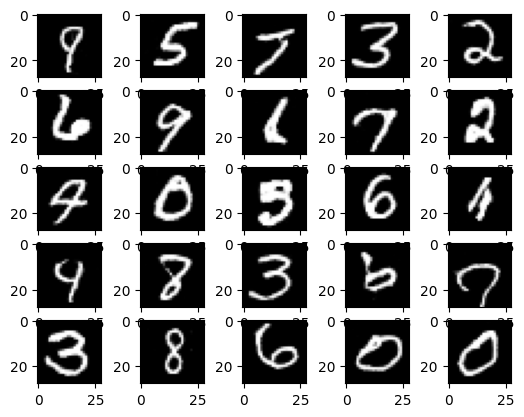

In [25]:
netG_BN.eval()
netD_BN.eval()

batch_size = 25
latent_size = 100

fixed_noise = torch.randn(batch_size, latent_size, 1, 1).to(device)

fake_images = netG_BN(fixed_noise)

fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
R, C = 5, 5
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i], cmap='gray')
plt.show()

In [ ]:
netD_SN = Discriminator_SN().to(device)
netD_SN.apply(weights_init)
netG_SN = Generator().to(device)
netG_SN.apply(weights_init)
nz = 100
# number of generator filters
ngf = 64
#number of discriminator filters
ndf = 64
criterion = nn.BCELoss()
# setup optimizer
optimizerD = optim.Adam(netD_SN.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG_SN.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

nepoch = 10
for epoch in range(nepoch):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD_SN.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device).to(torch.float32)

        output = netD_SN(real_cpu).to(torch.float32)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG_SN(noise)
        label.fill_(fake_label)
        output = netD_SN(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG_SN.zero_grad()
        label.fill_(real_label) 
        output = netD_SN(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                   % (epoch, nepoch, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            fake = netG_SN(fixed_noise)




In [ ]:
netG_BN.eval()
netD_BN.eval()

batch_size = 25
latent_size = 100

fixed_noise = torch.randn(batch_size, latent_size, 1, 1).to(device)

fake_images = netG_BN(fixed_noise)

fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
R, C = 5, 5
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i], cmap='gray')
plt.show()

In [ ]:
!pip install pytorch-ignite

In [ ]:
ignite.utils.manual_seed(999)

In [ ]:
ignite.utils.setup_logger(name="ignite.distributed.auto.auto_dataloader", level=logging.WARNING)
ignite.utils.setup_logger(name="ignite.distributed.launcher.Parallel", level=logging.WARNING)

In [ ]:
latent_dim = 100

In [ ]:
netG = idist.auto_model(Generator3x64x64(latent_dim))

In [ ]:
optimizerD = idist.auto_optim(
    optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
)

optimizerG = idist.auto_optim(
    optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
)

In [ ]:
real_label = 1
fake_label = 0


def training_step(engine, data):
    # Set the models for training
    netG.train()
    netD.train()

    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    ## Train with all-real batch
    netD.zero_grad()
    # Format batch
    real = data[0].to(idist.device())
    b_size = real.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=idist.device())
    # Forward pass real batch through D
    output1 = netD(real).view(-1)
    # Calculate loss on all-real batch
    errD_real = criterion(output1, label)
    # Calculate gradients for D in backward pass
    errD_real.backward()

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(b_size, latent_dim, 1, 1, device=idist.device())
    # Generate fake image batch with G
    fake = netG(noise)
    label.fill_(fake_label)
    # Classify all fake batch with D
    output2 = netD(fake.detach()).view(-1)
    # Calculate D's loss on the all-fake batch
    errD_fake = criterion(output2, label)
    # Calculate the gradients for this batch, accumulated (summed) with previous gradients
    errD_fake.backward()
    # Compute error of D as sum over the fake and the real batches
    errD = errD_real + errD_fake
    # Update D
    optimizerD.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output3 = netD(fake).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output3, label)
    # Calculate gradients for G
    errG.backward()
    # Update G
    optimizerG.step()

    return {
        "Loss_G" : errG.item(),
        "Loss_D" : errD.item(),
        "D_x": output1.mean().item(),
        "D_G_z1": output2.mean().item(),
        "D_G_z2": output3.mean().item(),
    }